# Libs Loading

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

import polars as pl
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


import data_squeeze_funcs as dsf
import data_loading_funcs as dlf
import modeling_functions as mf
import feature_engineering as fef
import feat_eng_pol as fepl

pygame 2.6.1 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


# 0. Data Loading

In [3]:
df_data = dlf.load_data_pl()
df_data.head(3)

id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,pre_loans5,pre_loans530,pre_loans3060,pre_loans6090,pre_loans90,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,pre_util,pre_over2limit,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_paym_0,enc_paym_1,enc_paym_2,enc_paym_3,enc_paym_4,enc_paym_5,enc_paym_6,enc_paym_7,enc_paym_8,enc_paym_9,enc_paym_10,enc_paym_11,enc_paym_12,enc_paym_13,enc_paym_14,enc_paym_15,enc_paym_16,enc_paym_17,enc_paym_18,enc_paym_19,enc_paym_20,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
i32,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,bool,bool,bool,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,bool,bool
0,1,18,9,2,3,16,10,11,3,3,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,true,true,true,0,0,3,3,3,3,3,3,3,3,3,4,3,3,3,3,3,3,3,3,4,3,3,3,4,1,3,4,1,false,false
0,2,18,9,14,14,12,12,0,3,3,2,11,6,16,5,4,8,1,1,1,1,1,16,2,17,true,true,true,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,3,4,1,false,false
0,3,18,9,4,8,1,11,11,0,5,2,8,6,16,5,4,8,1,1,1,1,1,15,2,17,false,true,true,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,1,2,3,1,true,true


In [4]:
df_target = dlf.load_target_pl()
# df_target = df_target.slice(250000, 500000)
df_target

id,flag
i32,i8
0,0
1,0
2,0
3,0
4,0
…,…
2999995,0
2999996,0
2999997,0


# 2. Feature Gambling

In [32]:
df_feat = df_data.clone()
df_feat.shape

(26162717, 60)

In [33]:
pre_loans_cols = ["pre_loans5", "pre_loans530", "pre_loans3060", "pre_loans6090", "pre_loans90"]
is_zero_loans_upto_60 = ['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060']
is_zero_loans_over_60 = ['is_zero_loans6090',	'is_zero_loans90']
is_zero_loans_total = [i for i in df_feat.columns if i.startswith('is_zero_loan')]
enc_paym_sum_cols = [i for i in df_feat.columns if i.startswith('enc_paym_')]



df_feat = df_feat.with_columns(
    pl.sum_horizontal(pre_loans_cols).alias("pre_loans_total").cast(pl.Int8),
    pl.sum_horizontal(is_zero_loans_upto_60).alias("is_zero_loans_upto_60").cast(pl.Int8),
    pl.sum_horizontal(is_zero_loans_over_60).alias("is_zero_loans_over_60").cast(pl.Int8),
    pl.sum_horizontal(is_zero_loans_total).alias("is_zero_loans_total").cast(pl.Int8),
    pl.sum_horizontal(enc_paym_sum_cols).alias("enc_paym_sum_total").cast(pl.Int16),
)

df_feat = fepl.credit_type_grpd(df_feat)
df_feat = fepl.cr_cost_rate_grpd(df_feat)
df_feat = fepl.pterm_grpd(df_feat)
df_feat = fepl.fterm_grpd(df_feat)
df_feat = fepl.cr_limit_grpd(df_feat)
df_feat = fepl.pre_util_grpd(df_feat)
df_feat = fepl.pre_over2limit_grpd(df_feat)
df_feat = fepl.pre_maxover2limit_grpd(df_feat)
df_feat = fepl.holder_type_grpd(df_feat)
df_feat = fepl.cr_status_grpd(df_feat)
df_feat = fepl.acc_cur_grpd(df_feat)
df_feat = fepl.since_op_grpd(df_feat)
df_feat = fepl.since_confrm_grpd(df_feat)
df_feat = fepl.till_pcl_grpd(df_feat)
df_feat = fepl.till_fcl_grpd(df_feat)
df_feat = fepl.next_pay_summ_grpd(df_feat)
df_feat = fepl.outstnd_grpd(df_feat)
df_feat = fepl.tot_overdue_grpd(df_feat)
df_feat = fepl.max_overdue_sum_grpd(df_feat)


# eps = 1e-6
# df_feat = df_feat.with_columns(
#     ((pl.col("pre_util_grpd") + eps) * (pl.col("is_zero_loans_total") + eps)).alias('util_no_overdue').cast(pl.Int8),
#     ((pl.col("pre_maxover2limit_grpd") + eps) * (pl.col("till_pcl_grpd") + eps)).alias('maxoverdue_till_pclose').cast(pl.Int8),
#     ((pl.col("till_fcl_grpd") + eps) * (pl.col("tot_overdue_grpd") + eps)).alias('delays_till_end').cast(pl.Int8),
#     ((pl.col("is_zero_loans_over_60") + eps) * (pl.col("tot_overdue_grpd") + eps)).alias('over60_totoverdue').cast(pl.Int8),
#     ((pl.col("is_zero_loans_upto_60") + eps) * (pl.col("till_fcl_grpd") + eps)).alias('upto60_fcl').cast(pl.Int8),
#     ((pl.col("outstnd_grpd") + eps) * (pl.col("is_zero_loans_total") + eps)).alias('outstnd_grpd * is0_tot').cast(pl.Int8),
# )

In [34]:
cols_to_drop = ["is_zero_loans_total"]

df_feat = df_feat.drop(pre_loans_cols + is_zero_loans_total + enc_paym_sum_cols + cols_to_drop)

In [35]:
df_feat = fepl.pl_featuretools(df_feat)

In [37]:
df_feat.shape

(3000000, 150)

In [8]:
df_feat_pd = df_feat.to_pandas()
df_target_pd = df_target.to_pandas()
df_feat_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26162717 entries, 0 to 26162716
Data columns (total 35 columns):
 #   Column                  Dtype
---  ------                  -----
 0   id                      int32
 1   rn                      int16
 2   is_zero_util            bool 
 3   is_zero_over2limit      bool 
 4   is_zero_maxover2limit   bool 
 5   pclose_flag             bool 
 6   fclose_flag             bool 
 7   is_zero_loans_upto_60   int8 
 8   is_zero_loans_over_60   int8 
 9   enc_paym_sum_total      int16
 10  credit_type_grpd        int8 
 11  cr_cost_rate_grpd       int8 
 12  pterm_grpd              int8 
 13  fterm_grpd              int8 
 14  cr_limit_grpd           int8 
 15  pre_util_grpd           int8 
 16  pre_over2limit_grpd     int8 
 17  pre_maxover2limit_grpd  int8 
 18  holder_type_grpd        int8 
 19  cr_status_grpd          int8 
 20  acc_cur_grpd            int8 
 21  since_op_grpd           int8 
 22  since_confrm_grpd       int8 
 23  till_

In [9]:
import featuretools as ft

dataframes = {
    'target': (df_target_pd, 'id'),
    'data': (df_feat_pd, 'unique')
}

relationships = [
    ('target', 'id', 'data', 'id')
]

fm, features_defs = ft.dfs(
    dataframes=dataframes,
    relationships=relationships,
    target_dataframe_name="target",
    max_depth=2,
    # trans_primitives=trans_primitives,
    # agg_primitives=agg_primitives,
    ignore_columns={'target': ['flag']},
)

fm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000000 entries, 0 to 2999999
Columns: 180 entries, COUNT(data) to SUM(data.util_no_overdue)
dtypes: Int64(1), float64(179)
memory usage: 4.0 GB


In [10]:
fm.head()

,COUNT(data),MAX(data.acc_cur_grpd),MAX(data.cr_cost_rate_grpd),MAX(data.cr_limit_grpd),MAX(data.cr_status_grpd),MAX(data.credit_type_grpd),MAX(data.delays_till_end),MAX(data.enc_paym_sum_total),MAX(data.fterm_grpd),MAX(data.holder_type_grpd),MAX(data.is_zero_loans_over_60),MAX(data.is_zero_loans_upto_60),MAX(data.max_overdue_sum_grpd),MAX(data.maxoverdue_till_pclose),MAX(data.next_pay_summ_grpd),MAX(data.outstnd_grpd),MAX(data.outstnd_grpd * is0_tot),MAX(data.over60_totoverdue),MAX(data.pre_maxover2limit_grpd),MAX(data.pre_over2limit_grpd),MAX(data.pre_util_grpd),MAX(data.pterm_grpd),MAX(data.rn),MAX(data.since_confrm_grpd),MAX(data.since_op_grpd),MAX(data.till_fcl_grpd),MAX(data.till_pcl_grpd),MAX(data.tot_overdue_grpd),MAX(data.upto60_fcl),MAX(data.util_no_overdue),MEAN(data.acc_cur_grpd),MEAN(data.cr_cost_rate_grpd),MEAN(data.cr_limit_grpd),MEAN(data.cr_status_grpd),MEAN(data.credit_type_grpd),MEAN(data.delays_till_end),MEAN(data.enc_paym_sum_total),MEAN(data.fterm_grpd),MEAN(data.holder_type_grpd),MEAN(data.is_zero_loans_over_60),MEAN(data.is_zero_loans_upto_60),MEAN(data.max_overdue_sum_grpd),MEAN(data.maxoverdue_till_pclose),MEAN(data.next_pay_summ_grpd),MEAN(data.outstnd_grpd),MEAN(data.outstnd_grpd * is0_tot),MEAN(data.over60_totoverdue),MEAN(data.pre_maxover2limit_grpd),MEAN(data.pre_over2limit_grpd),MEAN(data.pre_util_grpd),MEAN(data.pterm_grpd),MEAN(data.rn),MEAN(data.since_confrm_grpd),MEAN(data.since_op_grpd),MEAN(data.till_fcl_grpd),MEAN(data.till_pcl_grpd),MEAN(data.tot_overdue_grpd),MEAN(data.upto60_fcl),MEAN(data.util_no_overdue),MIN(data.acc_cur_grpd),MIN(data.cr_cost_rate_grpd),MIN(data.cr_limit_grpd),MIN(data.cr_status_grpd),MIN(data.credit_type_grpd),MIN(data.delays_till_end),MIN(data.enc_paym_sum_total),MIN(data.fterm_grpd),MIN(data.holder_type_grpd),MIN(data.is_zero_loans_over_60),MIN(data.is_zero_loans_upto_60),MIN(data.max_overdue_sum_grpd),MIN(data.maxoverdue_till_pclose),MIN(data.next_pay_summ_grpd),MIN(data.outstnd_grpd),MIN(data.outstnd_grpd * is0_tot),MIN(data.over60_totoverdue),MIN(data.pre_maxover2limit_grpd),MIN(data.pre_over2limit_grpd),MIN(data.pre_util_grpd),MIN(data.pterm_grpd),MIN(data.rn),MIN(data.since_confrm_grpd),MIN(data.since_op_grpd),MIN(data.till_fcl_grpd),MIN(data.till_pcl_grpd),MIN(data.tot_overdue_grpd),MIN(data.upto60_fcl),MIN(data.util_no_overdue),PERCENT_TRUE(data.fclose_flag),PERCENT_TRUE(data.is_zero_maxover2limit),PERCENT_TRUE(data.is_zero_over2limit),PERCENT_TRUE(data.is_zero_util),PERCENT_TRUE(data.pclose_flag),SKEW(data.acc_cur_grpd),SKEW(data.cr_cost_rate_grpd),SKEW(data.cr_limit_grpd),SKEW(data.cr_status_grpd),SKEW(data.credit_type_grpd),SKEW(data.delays_till_end),SKEW(data.enc_paym_sum_total),SKEW(data.fterm_grpd),SKEW(data.holder_type_grpd),SKEW(data.is_zero_loans_over_60),SKEW(data.is_zero_loans_upto_60),SKEW(data.max_overdue_sum_grpd),SKEW(data.maxoverdue_till_pclose),SKEW(data.next_pay_summ_grpd),SKEW(data.outstnd_grpd),SKEW(data.outstnd_grpd * is0_tot),SKEW(data.over60_totoverdue),SKEW(data.pre_maxover2limit_grpd),SKEW(data.pre_over2limit_grpd),SKEW(data.pre_util_grpd),SKEW(data.pterm_grpd),SKEW(data.rn),SKEW(data.since_confrm_grpd),SKEW(data.since_op_grpd),SKEW(data.till_fcl_grpd),SKEW(data.till_pcl_grpd),SKEW(data.tot_overdue_grpd),SKEW(data.upto60_fcl),SKEW(data.util_no_overdue),STD(data.acc_cur_grpd),STD(data.cr_cost_rate_grpd),STD(data.cr_limit_grpd),STD(data.cr_status_grpd),STD(data.credit_type_grpd),STD(data.delays_till_end),STD(data.enc_paym_sum_total),STD(data.fterm_grpd),STD(data.holder_type_grpd),STD(data.is_zero_loans_over_60),STD(data.is_zero_loans_upto_60),STD(data.max_overdue_sum_grpd),STD(data.maxoverdue_till_pclose),STD(data.next_pay_summ_grpd),STD(data.outstnd_grpd),STD(data.outstnd_grpd * is0_tot),STD(data.over60_totoverdue),STD(data.pre_maxover2limit_grpd),STD(data.pre_over2limit_grpd),STD(data.pre_util_grpd),STD(data.pterm_grpd),STD(data.rn),STD(data.since_confrm_grpd),STD(data.since_op_grpd),STD(data.till_fcl_grpd),STD(data.till_pcl_grpd),

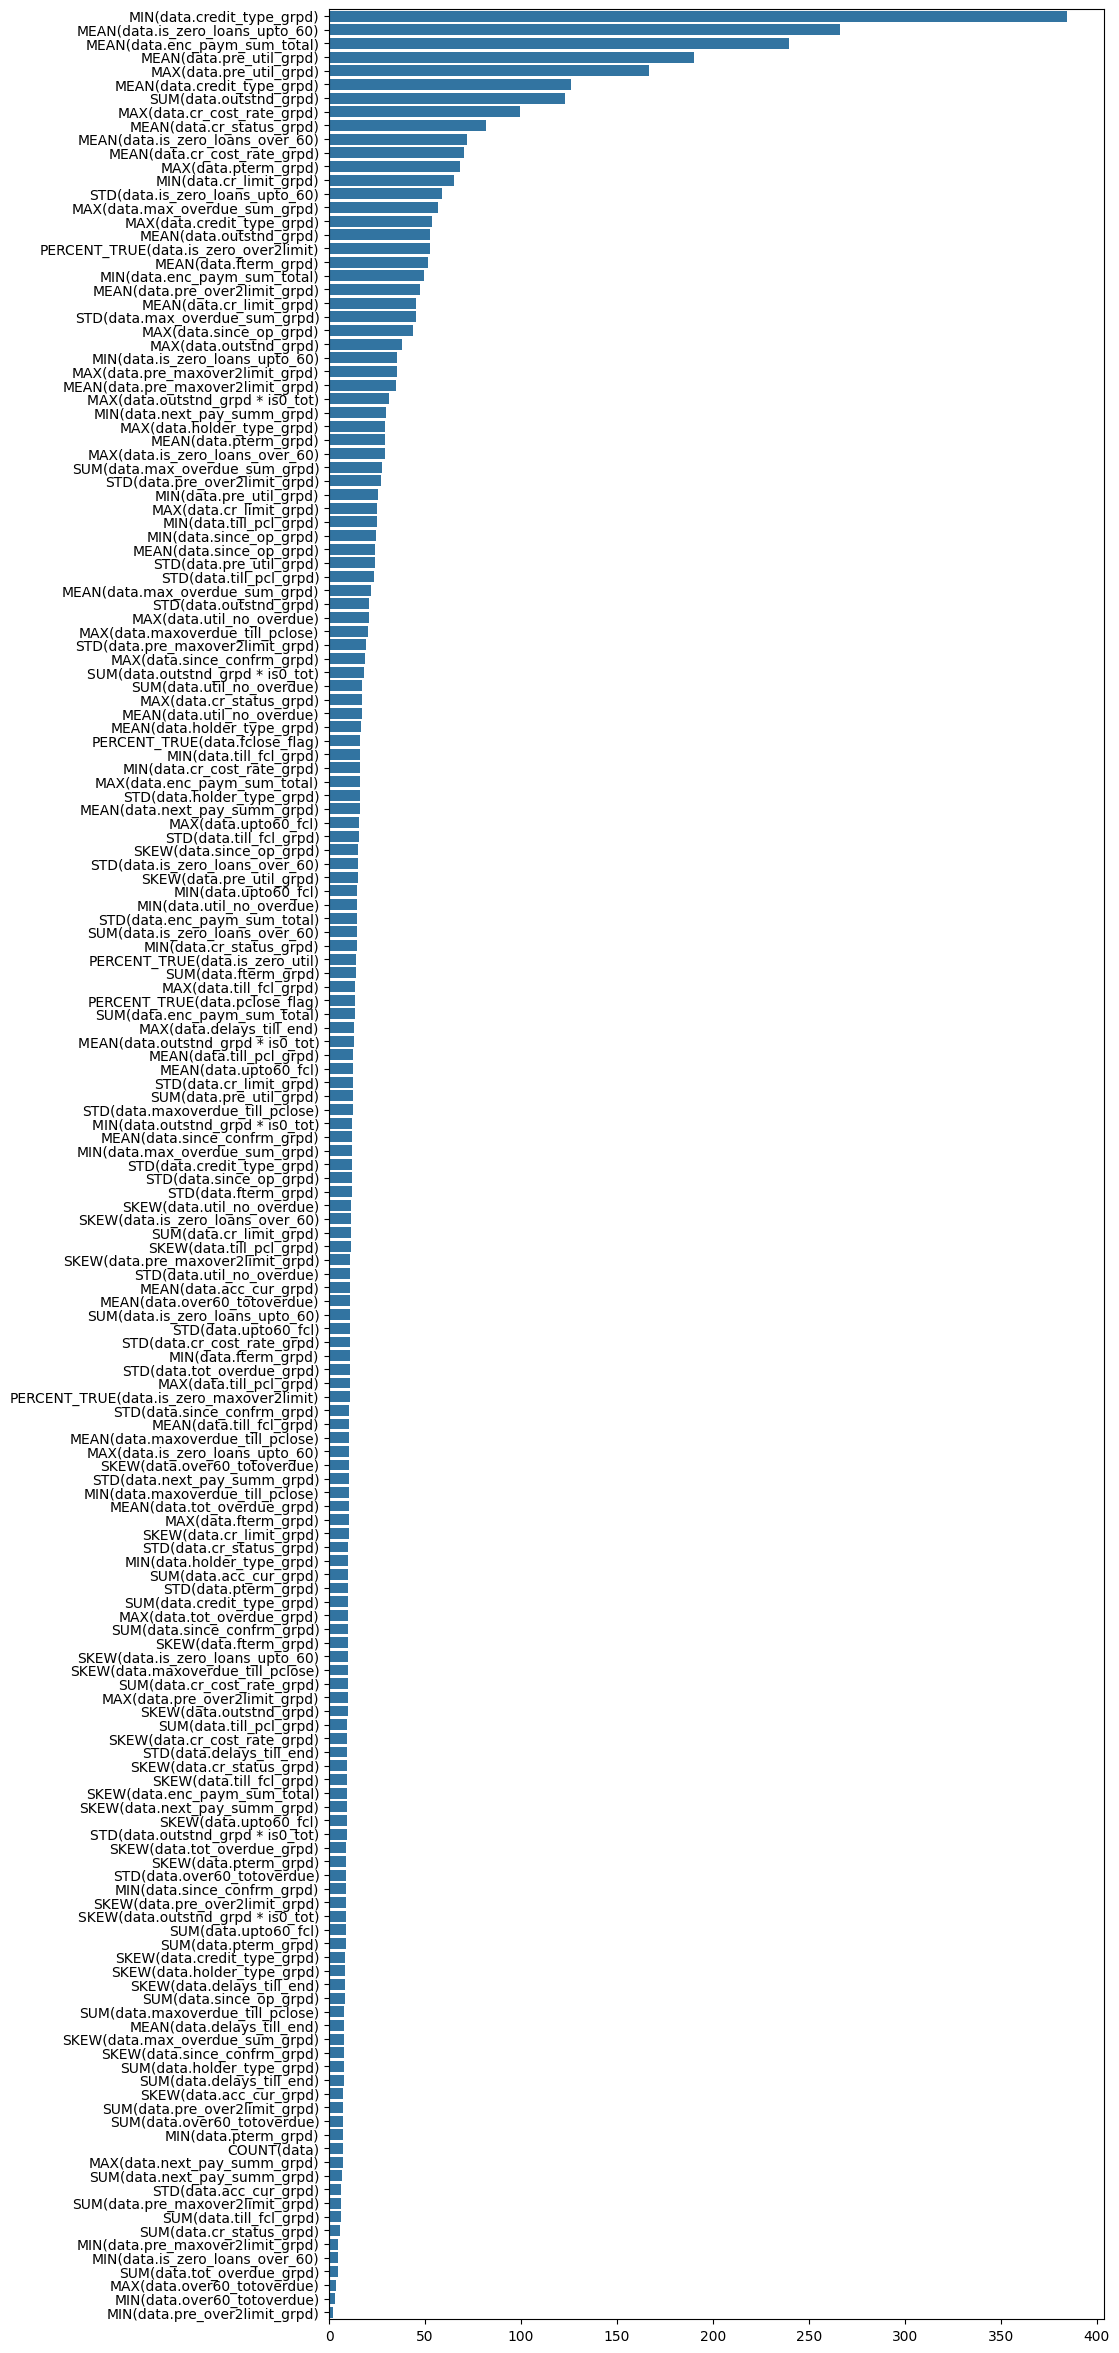

In [11]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Данные
X = fm
y = df_target_pd['flag']

# Создание и обучение модели
xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.12,
    random_state=137,
    verbosity=0,
    eval_metric='auc',
    tree_method='gpu_hist',
    enable_categorical=True
)

xgb.fit(X, y)

# Получение важности признаков
feature_importance = xgb.get_booster().get_score(importance_type='gain')

# Сортировка важности признаков
best_features_sorted = dict(
    sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
)

# Визуализация важности признаков
plt.figure(figsize=(10, 30))
sns.barplot(
    x=list(best_features_sorted.values()), 
    y=list(best_features_sorted.keys())
);



In [12]:
# Фильтрация признаков для нового DataFrame
feats_to_df_model = [feat for feat, val in best_features_sorted.items() if val > 10]
df_squeezed = X[feats_to_df_model].copy()
df_squeezed['flag'] = df_target['flag']

# Размер итогового DataFrame
print(df_squeezed.shape)

(3000000, 114)


# 3. Modeling

In [13]:
X = df_squeezed.drop(columns=['flag'])
y = df_squeezed.flag

# X = fm
# y = df_target_pd.flag


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, stratify=y, random_state=137
)

In [14]:
message = 'HP Optuna'

In [15]:
best_params_df = pd.read_csv('data/best_params.csv')
best_params = best_params_df.to_dict(orient='records')[0]

cbc_best = CatBoostClassifier(
    **best_params,
    random_seed=137,
    cat_features=[i for i in X.columns if X[i].dtype == "category"],
    eval_metric='AUC',
    task_type='GPU',
    logging_level='Silent',
    # iterations=1400,
    # max_depth=5,
    # learning_rate=.13,
    # l2_leaf_reg=.002,
    # border_count=87,
    # random_strength=.04,
    # bagging_temperature=0.06
)

cbc_best.fit(X_train, y_train)
y_pred = cbc_best.predict_proba(X_test)[:, 1]

score = roc_auc_score(y_test, y_pred)
with open("results.txt", "a") as f:
    string = f"AUC with {message:40}: {score:.2%}"
    print(string)
    f.write(f"\n{type(cbc_best).__name__}\n{string}\n")
fef.playsound()

Default metric period is 5 because AUC is/are not implemented for GPU


AUC with HP Optuna                               : 75.06%


In [16]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances


def objective(trial):
    params = {
        "cat_features": [i for i in X.columns if X[i].dtype == 'category'],
        "iterations": trial.suggest_int("iterations", 2000, 5000),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, .2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 5),
        "eval_metric": "AUC",
        "logging_level": 'Silent',
        "random_seed": 137,
        "task_type": "GPU",  # Для GPU: "GPU"
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 10),
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
        "auto_class_weights": "SqrtBalanced",
    }
    
    # Модель
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0)
    
    # Оценка качества
    y_pred = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred)
    return auc_score

# Запуск Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best score:', study.best_trial.value)

[I 2024-12-28 16:49:56,914] A new study created in memory with name: no-name-4d430dde-f5df-4c28-a882-44991d696d72


KeyboardInterrupt: 

Exception ignored in: '_catboost._WriteLog'
Traceback (most recent call last):
  File "c:\Users\User\skillbox\HOMEWORKS\HWs\Lib\site-packages\ipykernel\iostream.py", line 655, in write
    def write(self, string: str) -> Optional[int]:  # type:ignore[override]

KeyboardInterrupt: 
 is/are not implemented for GPU
[W 2024-12-28 16:51:05,226] Trial 0 failed with parameters: {'iterations': 3215, 'max_depth': 3, 'learning_rate': 0.0699412192359614, 'l2_leaf_reg': 0.006169650066920366, 'border_count': 224, 'random_strength': 0.5848382398487523, 'bagging_temperature': 2.4847115091197947, 'min_data_in_leaf': 22, 'grow_policy': 'SymmetricTree', 'one_hot_max_size': 5, 'leaf_estimation_iterations': 5, 'leaf_estimation_method': 'Newton'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\User\skillbox\HOMEWORKS\HWs\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^

KeyboardInterrupt: 

In [ ]:
best_params = study.best_trial.params
bp = pd.DataFrame([best_params])
bp.to_csv('data/best_params_3M_+HPs.csv', index=False)
bp

,iterations,max_depth,learning_rate,l2_leaf_reg,border_count,random_strength,bagging_temperature
0,1978,4,0.101156,0.005584,152,0.009753,1.017737


In [17]:
# best_params_df = pd.read_csv('data/best_params_3M.csv')
# best_params = best_params_df.to_dict(orient='records')[0]

best_params = {
    "iterations": 5000,
    "max_depth": 4,
    "learning_rate": 0.09,
    "l2_leaf_reg": 7,
    "border_count": 235,
    "random_strength": 0.15,
    "bagging_temperature": 0.3,
    "auto_class_weights": "SqrtBalanced",
}

cbc_best = CatBoostClassifier(
    **best_params,
    random_seed=137,
    cat_features=[i for i in X.columns if X[i].dtype == "category"],
    eval_metric="AUC",
    task_type="GPU",
    logging_level="Silent",
)

cbc_best.fit(X_train, y_train)
y_pred = cbc_best.predict_proba(X_test)[:, 1]

score = roc_auc_score(y_test, y_pred)
with open("results.txt", "a") as f:
    string = f"AUC with {message:40}: {score:.2%}"
    print(string)
    f.write(f"\n{type(cbc_best).__name__}\n{string}\n")
fef.playsound()

Default metric period is 5 because AUC is/are not implemented for GPU


AUC with HP Optuna                               : 75.17%


In [312]:
xgb_best_params = {
    'n_estimators': 1000,
    'max_depth': 4,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'min_child_weight': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': 137,
    'tree_method': 'gpu_hist',  # Использование GPU
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'enable_categorical': True
}

xgb = XGBClassifier(**xgb_best_params)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, stratify=y, random_state=137
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, y_pred)

with open("results.txt", "a") as f:
    string = f"AUC with {message:40}: {score:.2%}"
    print(string)
    f.write(f"\n{type(xgb).__name__}\n{string}\n")

# cv = cross_val_score(xgb, X, y, cv=5, scoring='roc_auc')
# cv_mean = cv.mean()
# with open("results.txt", "a") as f:
#     string = f"AUC on CV with {message:40}: {cv_mean:.2%}"
#     print(string)
#     f.write(f"\n{type(xgb).__name__}\n{string}\n")

AUC with all cats                                : 74.25%


In [44]:
best_params = {
    "iterations": 5000,
    "max_depth": 4,
    "learning_rate": 0.1,
    "l2_leaf_reg": 7,
    "border_count": 235,
    "random_strength": 0.15,
    "bagging_temperature": 0.3,
}

cbc = CatBoostClassifier(
    **best_params,
    # iterations=2000,
    # bagging_temperature=0.3,
    # learning_rate=0.012,
    # max_depth=4,
    # cat_features=[i for i in X_adasyn.columns if X_adasyn[i].dtype == "category"],
    random_seed=137,
    logging_level='Silent',
    eval_metric='AUC',
    task_type='GPU'
)

cv = cross_val_score(cbc, X, y, cv=5, scoring='roc_auc')
cv_mean = cv.mean()
with open("results.txt", "a") as f:
    string = f"AUC on CV with {message:40}: {cv_mean:.2%}"
    print(string)
    f.write(f"\n{type(cbc).__name__}\n{string}\n")

fef.playsound()

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


AUC on CV with squeezed                                : 75.03%


In [113]:
# # Создание и обучение модели
# xgb = XGBClassifier(
#     n_estimators=1000,
#     max_depth=4,
#     learning_rate=0.012,
#     random_state=137,
#     verbosity=0,
#     eval_metric='auc',
#     tree_method='gpu_hist',
#     enable_categorical=True
# )

# xgb.fit(X, y)

# # Получение важности признаков
# feature_importance = xgb.get_booster().get_score(importance_type='gain')

# # Сортировка важности признаков
# best_features_sorted = dict(
#     sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)
# )

# # Визуализация важности признаков
# plt.figure(figsize=(10, 15))
# sns.barplot(
#     x=list(best_features_sorted.values()), 
#     y=list(best_features_sorted.keys())
# )

# # Фильтрация признаков для нового DataFrame
# feats_to_df_model = [feat for feat, val in best_features_sorted.items() if val > 50]
# df_lessened = X[feats_to_df_model].copy()
# # df_lessened['flag'] = df_model['flag']

# # Размер итогового DataFrame
# print(df_lessened.shape)


In [114]:
# X = df_lessened
# y = df_model.flag

In [ ]:
# sq_rn = df_feat.lazy().group_by('id').agg(
#     pl.col('rn').max().alias('MAX_rn').cast(pl.Int8)
# )

# cols_to_skip = ['rn', 'id'] + [i for i in df_feat.columns if df_feat.schema[i] == pl.Boolean]

# sq_mean = df_feat.lazy().group_by('id').agg(
#     pl.col(col).mean().alias('MEAN_' + col) for col in df_feat.columns if col not in cols_to_skip
# ).sort('id').cast(pl.Int32)

# sq_max = df_feat.lazy().group_by('id').agg(
#     pl.col(col).max().alias('MAX_' + col) for col in df_feat.columns if col not in cols_to_skip
# ).sort('id')

# sq_min = df_feat.lazy().group_by('id').agg(
#     pl.col(col).min().alias('MIN_' + col) for col in df_feat.columns if col not in cols_to_skip
# ).sort('id')

# sq_var = df_feat.lazy().group_by('id').agg(
#     pl.col(col).var().alias('VAR_' + col) for col in df_feat.columns if col not in cols_to_skip
# ).sort('id')

# # sq_bool = df_feat.lazy().group_by('id').agg(
# #     pl.col(col).any().alias('ANY_' + col) for col in df_feat.columns if df_feat.schema[col] == pl.Boolean
# # )

# # sq_skew = df_feat.lazy().group_by('id').agg(
# #     pl.col(col).skew().alias('SKEW_' + col) for col in df_feat.columns if col not in cols_to_skip
# # ).sort('id')

# df_squeeze_mean = sq_mean.collect()
# df_squeeze_max = sq_max.drop('id').collect()
# df_squeeze_min = sq_min.drop('id').collect()
# df_squeeze_var = sq_var.drop('id').collect()
# # df_squeeze_skew = sq_skew.drop('id').collect()
# df_squeeze_rn = sq_rn.drop('id').collect()
# # df_squeeze_bool = sq_bool.drop('id').collect()

# df_squeeze = pl.concat([df_squeeze_rn, df_squeeze_mean, df_squeeze_max, df_squeeze_min, df_squeeze_var], how='horizontal')

# df_squeeze = df_squeeze.with_columns(pl.col("id").cast(pl.Int32))

# df_squeeze = df_squeeze.with_columns(
#     pl.col(col).cast(pl.Int32) for col in df_squeeze.columns if col != "id" and df_squeeze[col].dtype not in [pl.Float32, pl.Boolean]
# )


# df_squeeze


MAX_rn,id,MEAN_pre_since_confirmed,MEAN_pre_pterm,MEAN_pre_fterm,MEAN_pre_loans_credit_limit,MEAN_pre_loans_next_pay_summ,MEAN_pre_loans_outstanding,MEAN_pre_loans_total_overdue,MEAN_pre_loans_max_overdue_sum,MEAN_pre_loans_credit_cost_rate,MEAN_pre_over2limit,MEAN_pre_maxover2limit,MEAN_enc_loans_account_holder_type,MEAN_enc_loans_credit_status,MEAN_enc_loans_account_cur,MEAN_pclose_flag,MEAN_fclose_flag,MEAN_enc_loans_credit_type_grouped,MEAN_pre_loans_total,MEAN_is_zero_loans_upto_60,MEAN_is_zero_loans_over_60,MEAN_enc_paym_sum_total,MEAN_total_fperiod,MEAN_total_pperiod,MEAN_util_no_overdue,MEAN_maxoverdue_till,MEAN_delays_till_end,MEAN_maxoverdue_till_end,MAX_pre_since_confirmed,MAX_pre_pterm,MAX_pre_fterm,MAX_pre_loans_credit_limit,MAX_pre_loans_next_pay_summ,MAX_pre_loans_outstanding,MAX_pre_loans_total_overdue,MAX_pre_loans_max_overdue_sum,…,MIN_pre_loans_total,MIN_is_zero_loans_upto_60,MIN_is_zero_loans_over_60,MIN_enc_paym_sum_total,MIN_total_fperiod,MIN_total_pperiod,MIN_util_no_overdue,MIN_maxoverdue_till,MIN_delays_till_end,MIN_maxoverdue_till_end,VAR_pre_since_confirmed,VAR_pre_pterm,VAR_pre_fterm,VAR_pre_loans_credit_limit,VAR_pre_loans_next_pay_summ,VAR_pre_loans_outstanding,VAR_pre_loans_total_overdue,VAR_pre_loans_max_overdue_sum,VAR_pre_loans_credit_cost_rate,VAR_pre_over2limit,VAR_pre_maxover2limit,VAR_enc_loans_account_holder_type,VAR_enc_loans_credit_status,VAR_enc_loans_account_cur,VAR_pclose_flag,VAR_fclose_flag,VAR_enc_loans_credit_type_grouped,VAR_pre_loans_total,VAR_is_zero_loans_upto_60,VAR_is_zero_loans_over_60,VAR_enc_paym_sum_total,VAR_total_fperiod,VAR_total_pperiod,VAR_util_no_overdue,VAR_maxoverdue_till,VAR_delays_till_end,VAR_maxoverdue_till_end
i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,f32,f32,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f32,f32,f32
5,0,7,7,7,9,3,2,0,2,8,2,15,1,2,1,0,0,1,39,2,2,42,18,19,101,178,444,22,12,15,14,16,5,5,0,2,…,39,2,2,6,9,14,7,17.000017,39.000038,2.000003,14,29,22,32,2,0,0,0,14,0,16,0,0,0,0,0,0,0,0,0,617,56,47,1752,7551.734375,28797.601562,75.733414
16,1,7,6,7,8,2,2,0,1,3,2,15,1,2,1,0,0,1,39,2,1,44,18,21,89,160,392,18,14,15,16,19,5,4,0,3,…,39,2,0,4,9,8,0,17.000017,39.000038,3.000004,14,29,24,37,1,0,0,0,3,5,8,0,0,0,0,0,0,0,0,0,584,46,47,2648,5432.994629,22806.644531,74.071495
3,2,10,7,6,1,1,3,0,1,4,2,15,1,2,1,0,0,2,34,2,1,49,17,13,55,83,190,9,14,13,8,3,2,4,0,2,…,25,1,1,23,11,1,18,11.000011,25.000027,1.000002,8,27,12,1,0,1,0,0,1,0,12,0,0,0,0,0,0,65,1,0,758,36,156,3926,14292.0,75257.34375,200.333542
1,3,7,7,7,9,2,3,0,2,4,2,16,1,2,1,0,0,2,39,3,2,28,15,12,92,87,202,10,16,16,16,18,6,5,0,2,…,39,3,2,3,3,3,14,4.000004,39.000038,2.000003,20,33,19,32,1,0,0,0,7,0,11,0,0,0,0,0,0,0,0,0,659,43,79,2246,6675.26709,34374.605469,90.400093
9,4,9,4,8,12,1,3,0,2,0,2,17,1,2,1,1,1,2,39,3,2,78,23,13,128,17,39,2,9,4,8,12,1,3,0,2,…,39,3,2,78,23,13,128,17.000017,39.000038,2.000003,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
17,2999995,9,8,8,7,2,3,0,2,5,2,17,1,2,1,0,0,1,38,2,2,32,17,17,97,149,340,19,17,17,16,14,4,5,0,3,…,36,2,2,6,11,5,50,17.000017,36.000038,1.000002,17,28,17,22,0,0,0,0,7,0,0,0,0,0,0,0,0,1,0,0,417,39,54,752,9121.891602,47056.09375,181.472885
4,2999996,11,9,8,11,1,3,0,2,3,2,15,1,2,1,0,0,1,39,2,2,38,14,14,97,105,246,12,17,16,15,19,2,4,0,2,…,39,1,2,3,5,2,28,4.000004,39.000038,2.000003,17,24,27,39,0,0,0,0,11,1,23,0,0,0,0,0,0,0,0,0,419,35,52,1807,10548.360352,53332.503906,140.256561
17,2999997,7,8,7,7,2,3,0,1,5,2,15,1,2,1,0,0,2,39,2,2,40,17,16,89,117,319,14,16,15,15,17,6,4,0,2,…,39,2,2,3,8,4,24,0.000017,0.000039,0.000002,28,31,22,24,2,0,0,0,16,0,19,0,0,0,0,

In [ ]:
# df = df_squeeze.join(df_target, on='id', how='left')
# df

MAX_rn,id,MEAN_pre_since_confirmed,MEAN_pre_pterm,MEAN_pre_fterm,MEAN_pre_loans_credit_limit,MEAN_pre_loans_next_pay_summ,MEAN_pre_loans_outstanding,MEAN_pre_loans_total_overdue,MEAN_pre_loans_max_overdue_sum,MEAN_pre_loans_credit_cost_rate,MEAN_pre_over2limit,MEAN_pre_maxover2limit,MEAN_enc_loans_account_holder_type,MEAN_enc_loans_credit_status,MEAN_enc_loans_account_cur,MEAN_pclose_flag,MEAN_fclose_flag,MEAN_enc_loans_credit_type_grouped,MEAN_pre_loans_total,MEAN_is_zero_loans_upto_60,MEAN_is_zero_loans_over_60,MEAN_enc_paym_sum_total,MEAN_total_fperiod,MEAN_total_pperiod,MEAN_util_no_overdue,MEAN_maxoverdue_till,MEAN_delays_till_end,MEAN_maxoverdue_till_end,MAX_pre_since_confirmed,MAX_pre_pterm,MAX_pre_fterm,MAX_pre_loans_credit_limit,MAX_pre_loans_next_pay_summ,MAX_pre_loans_outstanding,MAX_pre_loans_total_overdue,MAX_pre_loans_max_overdue_sum,…,MIN_is_zero_loans_upto_60,MIN_is_zero_loans_over_60,MIN_enc_paym_sum_total,MIN_total_fperiod,MIN_total_pperiod,MIN_util_no_overdue,MIN_maxoverdue_till,MIN_delays_till_end,MIN_maxoverdue_till_end,VAR_pre_since_confirmed,VAR_pre_pterm,VAR_pre_fterm,VAR_pre_loans_credit_limit,VAR_pre_loans_next_pay_summ,VAR_pre_loans_outstanding,VAR_pre_loans_total_overdue,VAR_pre_loans_max_overdue_sum,VAR_pre_loans_credit_cost_rate,VAR_pre_over2limit,VAR_pre_maxover2limit,VAR_enc_loans_account_holder_type,VAR_enc_loans_credit_status,VAR_enc_loans_account_cur,VAR_pclose_flag,VAR_fclose_flag,VAR_enc_loans_credit_type_grouped,VAR_pre_loans_total,VAR_is_zero_loans_upto_60,VAR_is_zero_loans_over_60,VAR_enc_paym_sum_total,VAR_total_fperiod,VAR_total_pperiod,VAR_util_no_overdue,VAR_maxoverdue_till,VAR_delays_till_end,VAR_maxoverdue_till_end,flag
i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,f32,f32,f32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f32,f32,f32,i8
5,0,7,7,7,9,3,2,0,2,8,2,15,1,2,1,0,0,1,39,2,2,42,18,19,101,178,444,22,12,15,14,16,5,5,0,2,…,2,2,6,9,14,7,17.000017,39.000038,2.000003,14,29,22,32,2,0,0,0,14,0,16,0,0,0,0,0,0,0,0,0,617,56,47,1752,7551.734375,28797.601562,75.733414,0
16,1,7,6,7,8,2,2,0,1,3,2,15,1,2,1,0,0,1,39,2,1,44,18,21,89,160,392,18,14,15,16,19,5,4,0,3,…,2,0,4,9,8,0,17.000017,39.000038,3.000004,14,29,24,37,1,0,0,0,3,5,8,0,0,0,0,0,0,0,0,0,584,46,47,2648,5432.994629,22806.644531,74.071495,0
3,2,10,7,6,1,1,3,0,1,4,2,15,1,2,1,0,0,2,34,2,1,49,17,13,55,83,190,9,14,13,8,3,2,4,0,2,…,1,1,23,11,1,18,11.000011,25.000027,1.000002,8,27,12,1,0,1,0,0,1,0,12,0,0,0,0,0,0,65,1,0,758,36,156,3926,14292.0,75257.34375,200.333542,0
1,3,7,7,7,9,2,3,0,2,4,2,16,1,2,1,0,0,2,39,3,2,28,15,12,92,87,202,10,16,16,16,18,6,5,0,2,…,3,2,3,3,3,14,4.000004,39.000038,2.000003,20,33,19,32,1,0,0,0,7,0,11,0,0,0,0,0,0,0,0,0,659,43,79,2246,6675.26709,34374.605469,90.400093,0
9,4,9,4,8,12,1,3,0,2,0,2,17,1,2,1,1,1,2,39,3,2,78,23,13,128,17,39,2,9,4,8,12,1,3,0,2,…,3,2,78,23,13,128,17.000017,39.000038,2.000003,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
17,2999995,9,8,8,7,2,3,0,2,5,2,17,1,2,1,0,0,1,38,2,2,32,17,17,97,149,340,19,17,17,16,14,4,5,0,3,…,2,2,6,11,5,50,17.000017,36.000038,1.000002,17,28,17,22,0,0,0,0,7,0,0,0,0,0,0,0,0,1,0,0,417,39,54,752,9121.891602,47056.09375,181.472885,0
4,2999996,11,9,8,11,1,3,0,2,3,2,15,1,2,1,0,0,1,39,2,2,38,14,14,97,105,246,12,17,16,15,19,2,4,0,2,…,1,2,3,5,2,28,4.000004,39.000038,2.000003,17,24,27,39,0,0,0,0,11,1,23,0,0,0,0,0,0,0,0,0,419,35,52,1807,10548.360352,53332.503906,140.256561,0
17,2999997,7,8,7,7,2,3,0,1,5,2,15,1,2,1,0,0,2,39,2,2,40,17,16,89,117,319,14,16,15,15,17,6,4,0,2,…,2,2,3,8,4,24,0.000017,0.000039,0.000002,28,31,22,24,2,0,0,0,16,0,19,0,0,0,0,0,0,0,0,0,478,53,110,1927,

In [ ]:
# df_model = df.drop('id').to_pandas()
# df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 110 entries, MAX_rn to flag
dtypes: float32(9), float64(24), int32(76), int8(1)
memory usage: 1.5 GB


In [ ]:
# from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SelectByShuffling
# from sklearn.ensemble import RandomForestClassifier

# X = fm
# y = df_target_pd['flag']

# # 1. Удаление константных признаков
# constant_filter = DropConstantFeatures(tol=0.95)
# X = constant_filter.fit_transform(X)

# # 2. Удаление коррелированных признаков
# correlation_filter = DropCorrelatedFeatures(threshold=0.85)
# X = correlation_filter.fit_transform(X)

# # 3. Отбор на основе важности признаков
# model = RandomForestClassifier(random_state=42)
# shuffling_selector = SelectByShuffling(estimator=model, scoring="roc-auc", random_state=42)
# X = shuffling_selector.fit_transform(X, y)
# len(X)

ValueError: Some of the variables in the dataset contain NaN. Check and remove those before using this transformer.